In [2]:
import math
import matplotlib.pyplot as plt
import torch
import random
torch.set_grad_enabled(False)

%matplotlib inline

In [3]:
class Module:
    def __init__(self):
        self.training = True
    
    def forward(self, *input):
        raise NotImplementedError()
    
    def backward(self, *gradwrtoutput):
        raise NotImplementedError()
        
    def param(self):
        return []
    
    def train(self):
        self.training = True
    
    def eval(self):
        self.training = False

In [4]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        
        stdv = 1. / n_in ** 0.5
        self.W = (torch.rand(n_out, n_in) - 0.5) * 2 * stdv
        self.b = (torch.rand(n_out) - 0.5) * 2 * stdv
        
        self.gradW = torch.zeros_like(self.W)
        self.gradb = torch.zeros_like(self.b)
    
    def forward(self, input):
        self.input = input
        
        return input @ self.W.T + self.b
    
    def backward(self, gradwrtoutput):
        self.gradW += (self.input[:, None, :] * gradwrtoutput[:, :, None]).sum(axis=0)
        self.gradb += gradwrtoutput.sum(axis=0)
        
        return gradwrtoutput @ self.W
        
    def param(self):
        return [(self.W, self.gradW), (self.b, self.gradb)]

In [45]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        if self.training and self.p < 1.:
            self.mask = torch.bernoulli(torch.ones_like(input) - self.p)
            return input * self.mask / (1 - self.p)
        else:
            return input
        
    def backward(self, gradwrtoutput):
        if self.training and self.p < 1.:
            return gradwrtoutput * self.mask / (1 - self.p)
        else:
            return gradwrtoutput

In [46]:
class ReLU(Module):
    def forward(self, input):
        self.mask = input > 0
        return input * self.mask
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput * self.mask

In [47]:
class Tanh(Module):
    def forward(self, input):
        self.exp = torch.exp(input)
        self.exp_minus = torch.exp(-input)
        self.output = (self.exp - self.exp_minus) / (self.exp + self.exp_minus)
        
        return self.output
    
    def backward(self, gradwrtoutput):
        return (1 - self.output ** 2) * gradwrtoutput

In [48]:
class Sigmoid(Module):
    def forward(self, input):
        self.output = 1 / (1 + torch.exp(-input))
        
        return self.output
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput * self.output * (1 - self.output)

In [49]:
class LossMSE(Module):
    def forward(self, input, target):
        self.diff = input - target
        return (self.diff ** 2).sum() / input.shape[0]
    
    def backward(self):
        return 2 * self.diff / self.diff.shape[0]

In [50]:
class LossBCE(Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.EPS = eps
        
    def forward(self, input, target):
        self.input = torch.clamp(input, self.EPS, 1 - self.EPS)
        self.target = target
        
        return (-target * self.input.log() - (1-target) * (1-self.input).log()).sum() / self.input.shape[0]
    
    def backward(self):
        return (-self.target / self.input + (1 - self.target) / (1 - self.input)) / self.input.shape[0]

In [51]:
class Sequential(Module):
    def __init__(self, modules):
        super().__init__()
        self.modules = modules
    
    def forward(self, input):
        output = input
        for module in self.modules:
            output = module.forward(output)
            
        return output
    
    def backward(self, gradwrtoutput):
        for module in self.modules[::-1]:
            gradwrtoutput = module.backward(gradwrtoutput)
        
        return gradwrtoutput
    
    def param(self):
        return [p for module in self.modules for p in module.param()]
    
    def train(self):
        super().train()
        
        for module in self.modules:
            module.train()
            
    def eval(self):
        super().eval()
        
        for module in self.modules:
            module.eval()

In [52]:
class Optimizer:
    def __init__(self, param):
        self.param = param
        
    def step(self):
        raise NotImplementedError()
        
    def zero_grad(self):
        for _, g in self.param:
            g[:] = 0.

In [53]:
class SGD(Optimizer):
    def __init__(self, param, lr=1.):
        super().__init__(param)
        
        self.lr = lr
        
    def step(self):
        for p, grad in self.param:
            p[:] = p - self.lr * grad

In [54]:
def batchify(dataset, batch_size=1, shuffle=True):
    X, y = dataset
    order = list(range(len(y)))
    
    if shuffle:
        random.shuffle(order)
        
    for start in range(0, len(order), batch_size):
        batch_idx = order[start:start + batch_size]
        
        yield X[batch_idx], y[batch_idx]

In [55]:
def generate_data(size):
    x = torch.rand(size, 2)
    y = (((x - 0.5) ** 2).sum(dim=1) <= 1 / (2 * math.pi)).int()
    
    return x, y

In [56]:
X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(1000)

In [59]:
net = Sequential([
    Linear(2, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 1)
])
loss = LossMSE()
opt = SGD(net.param(), lr=0.05)

n_epochs = 200
batch_size = 100
train_mse = []
test_acc = []

for _ in range(n_epochs):
    net.train()
    for X, y in batchify((X_train, y_train), batch_size=batch_size):
        opt.zero_grad()
        pred = net.forward(X)
        train_mse.append(loss.forward(pred, y.reshape(-1, 1)))
        net.backward(loss.backward())
        opt.step()
        
    net.eval()
    acc = 0.
    for X, y in batchify((X_test, y_test), batch_size=100):
        pred = net.forward(X)
        acc += ((pred.reshape(-1) > 0.5) == y).sum()
    acc /= len(y_test)
    test_acc.append(acc)

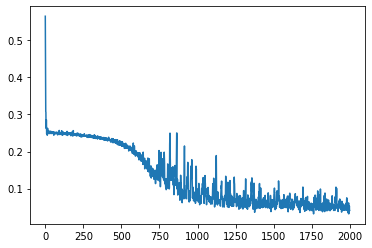

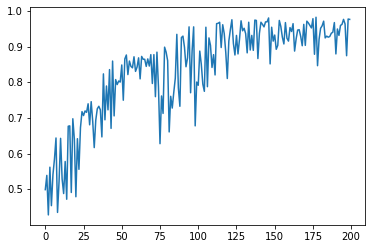

In [60]:
plt.plot(train_mse)
plt.show()
plt.plot(test_acc)
plt.show()

In [400]:
print(np.mean(test_acc[-10:]))

0.9788


In [395]:
net = Sequential([
    Linear(2, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 1),
    Sigmoid()
])
loss = LossBCE()
opt = SGD(net.param(), lr=0.01)

n_epochs = 2000
batch_size = 100
train_loss = []
test_acc = []

for _ in range(n_epochs):
    net.train()
    for X, y in batchify((X_train, y_train), batch_size=100):
        opt.zero_grad()
        pred = net.forward(X)
        train_loss.append(loss.forward(pred, y.reshape(-1, 1)))
        net.backward(loss.backward())
        opt.step()
        
    net.eval()
    acc = 0.
    for X, y in batchify((X_test, y_test), batch_size=100):
        pred = net.forward(X)
        acc += ((pred.reshape(-1) > 0.5) == y).sum()
    acc /= len(y_test)
    test_acc.append(acc)

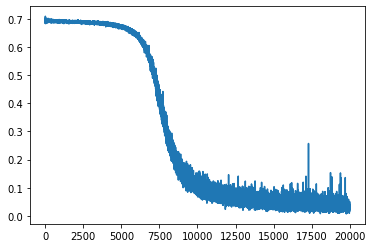

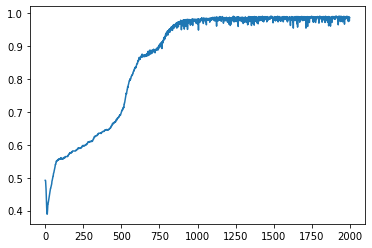

In [396]:
plt.plot(train_loss)
plt.show()
plt.plot(test_acc)
plt.show()

In [397]:
print(np.mean(test_acc[-10:]))

0.98389995


In [282]:
X, y = generate_data(100)

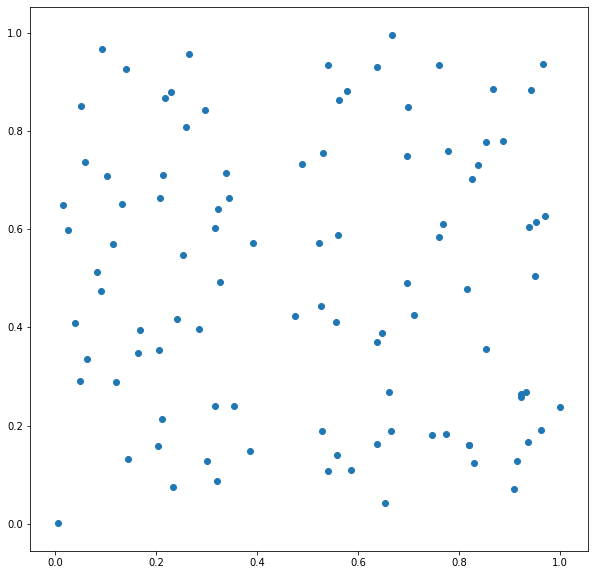

In [283]:
plt.figure(figsize=(10, 10))
plt.scatter(*list(zip(*X.numpy())))

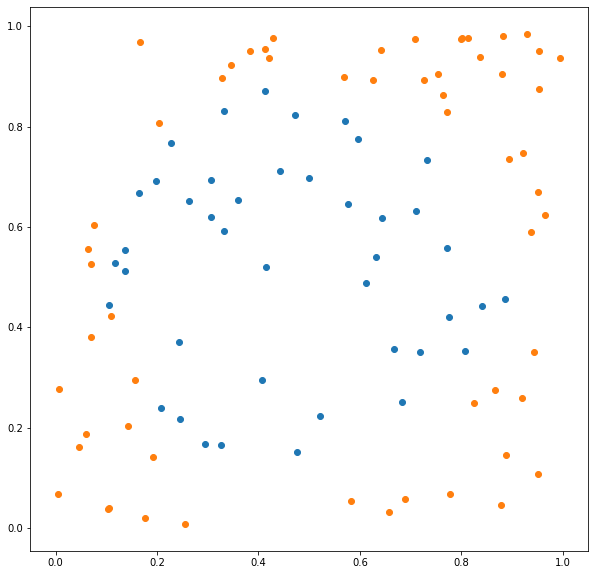

In [197]:
import numpy as np

plt.figure(figsize=(10, 10))
plt.scatter(*list(zip(*X.numpy()[y.numpy()])))
plt.scatter(*list(zip(*X.numpy()[np.logical_not(y.numpy())])))
plt.show()

In [168]:
x = Linear(2, 3)

In [153]:
opt = SGD(x.param())

In [154]:
inp = torch.rand(2, 2)

In [155]:
y = x.forward(inp)
print(y)
z = x.backward(y)
print(z)

tensor([[ 0.4123, -1.2918, -0.6931],
        [ 0.3759, -1.3442, -0.7828]])
tensor([[0.9634, 0.6435],
        [1.0310, 0.6604]])


In [156]:
x.param()

[(tensor([[-0.1509,  0.0273],
          [-0.6152, -0.5570],
          [-0.3330,  0.1259]]), tensor([[ 0.5034,  0.4918],
          [-1.7023, -1.6323],
          [-0.9597, -0.9097]])),
 (tensor([ 0.4743, -0.5762, -0.6018]), tensor([ 0.7882, -2.6359, -1.4760]))]

In [157]:
opt.zero_grad()
x.param()

[(tensor([[-0.1509,  0.0273],
          [-0.6152, -0.5570],
          [-0.3330,  0.1259]]), tensor([[0., 0.],
          [0., 0.],
          [0., 0.]])),
 (tensor([ 0.4743, -0.5762, -0.6018]), tensor([0., 0., 0.]))]

In [128]:
opt.param

[(tensor([[0., 0.],
          [0., 0.],
          [0., 0.]]), tensor([[0., 0.],
          [0., 0.],
          [0., 0.]])), (tensor([0., 0., 0.]), tensor([0., 0., 0.]))]

In [293]:
x = torch.rand(2, 3)
y = torch.rand(2, 4)

In [295]:
x.log()

tensor([[-1.1882, -0.6636, -1.3238],
        [-0.3836, -0.3140, -1.3192]])

In [102]:
(x[:, None, :] * y[:, :, None]).sum(axis=1)

tensor([[0.3806, 1.0598, 1.0172],
        [0.9166, 1.4628, 0.9720]])

In [20]:
x @ y.T

RuntimeError: size mismatch, m1: [2 x 3], m2: [4 x 2] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:197